## PAMSO

In [1]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
import itertools

import pandas as pd

model = ConcreteModel()

def fsmodel():
    model = ConcreteModel()
    
    # 5D Array
    model.gen = Set(initialize=[1, 2])  # Generators
    model.Periods = Set(initialize=[1, 2, 3])  # Time periods
    model.days = Set(initialize=[1, 2, 3])  # Demand scenario for time period 1
    
    # Total Scenarios
    
    file_path = 'newgenexp.xlsx'
    sheet_name = 'DIC'  # Specify the sheet name or sheet number
    
    # Load the data into a pandas DataFrame
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    c = {}
    for i in range(0,df.shape[0]):
        c[df['Generator'][i]] = df['Ammortized Fixed operating cost($)'][i]
    model.c = Param(model.gen, initialize=c)  # Fixed cost per unit capacity of generator j
    
    sheet_name = 'FIXOP'  # Specify the sheet name or sheet number
    
    # Load the data into a pandas DataFrame
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    f = {}
    for i in range(0,df.shape[0]):
        f[(df['Generator'][i],df['Period'][i])] = df['FIXOP'][i]
    model.f = Param(model.gen,model.Periods, initialize=f)  # Fixed cost per unit capacity of generator j
    
    sheet_name = 'Additional cost'  # Specify the sheet name or sheet number
    
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    g = {}
    for i in range(0,df.shape[0]):
        g[df['Day'][i]] = df['Cost'][i]
    model.g = Param(model.days, initialize=g)
    
    
    
    d = {}
    
    sheet_name = 'Demand'
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    for i in range(0,df.shape[0]):
        d[df['Day'][i],df['Period'][i]]= df['Demand (KWh)'][i]
        
                           
                   
    model.d = Param(model.Periods,model.days, initialize=d)  # Fixed cost per unit capacity of generator j
    
                           
       
    a = {}    
    sheet_name = 'Availability'
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    for i in range(0,df.shape[0]):
        a[df['Day'][i],df['Period'][i],df['Generator'][i]]= df['Availibility'][i]
        
                           
    model.a = Param(model.Periods,model.days,model.gen, initialize=a)  # Fixed cost per unit capacity of generator j
    
    # Variables
    model.x = Var(model.gen, domain=NonNegativeReals)  # Installed capacity of generator j
    model.y = Var(model.days,model.Periods, model.gen, domain=NonNegativeReals)  # Operating level of generator j
    model.y_purchased = Var(model.days,model.Periods, domain=NonNegativeReals)  # Additional capacity purchased
    # Objective function
    def objective_rule(model):
        fixed_cost = 3*sum(model.c[j] * model.x[j] for j in model.gen)
        operating_cost = sum(sum(sum(model.f[j,i] * model.y[s,i,j] for j in model.gen) + model.g[s] * model.y_purchased[s,i] for i in model.Periods) for s in model.days)
        return fixed_cost + operating_cost
    
    model.obj = Objective(rule=objective_rule, sense=minimize)
    
    # Constraints
    #Constraint for fixing x values
    

    # Demand satisfaction constraints
    def demand_satisfaction_rule(model, s, i):
        return sum(model.y[s,i,j] for j in model.gen) + model.y_purchased[s,i] >= model.d[s,i]
    model.demand_satisfaction_constraint = Constraint(model.days,model.Periods, rule=demand_satisfaction_rule)
    
    # Availability constraints
    def availability_rule(model,s,i, gen):
        return model.y[s,i,gen] <= model.a[s,i,gen] * model.x[gen]
    model.availability_constraint = Constraint(model.days,model.Periods,model.gen, rule=availability_rule)
    return model


## Parameterized high-level model
We formulate the parameterzied high-level model as follows:
$$
   \begin{align}
        \min \quad & \phi =  \sum_{s \in \set{S}}\sum_{j \in \set{J}}c_{j}x_{j} + \sum_{s \in \set{S}}\left(\sum_{j \in \set{J}}\sum_{i\in \set{I}}\left(f_{i,j}\right)y_{j} +g_{s} \tilde{y}\right) & \\
        \text{s.t. } \quad & x_{j} \geq 0 \quad \forall\: j \in \set{J} & \\
        & y_j \leq \rho_j\sum_{s \in \set{S}}\sum_{i \in \set{I}}a_{i,k,j}x_j \quad \forall\: j \in \set{J}  & \\
        & \sum_{j \in \set{J}}y_{j}+ \tilde{y} \geq  \sum_{k \in \set{K}}\sum_{i \in \set{I}}d_{i,k} & \\
        & x_{j} \geq \rho_3 \quad \forall\: j \in \set{J} & \\
        & y_{j} \geq 0 \quad \forall\:j \in \set{J} & \\
          &  \tilde{y} \geq 0 &  
    \end{align}
$$

In [2]:
def hlmodel(param_val):
    model = ConcreteModel()
    
    # 5D Array
    model.gen = Set(initialize=[1, 2])  # Generators
    model.Periods = Set(initialize=[1, 2, 3])  # Time periods
    model.days = Set(initialize=[1, 2, 3])  # Demand scenario for time period 1
    
    # Total Scenarios
    
    file_path = 'newgenexp.xlsx'
    sheet_name = 'DIC'  # Specify the sheet name or sheet number
    
    # Load the data into a pandas DataFrame
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    c = {}
    for i in range(0,df.shape[0]):
        c[df['Generator'][i]] = df['Ammortized Fixed operating cost($)'][i]
    model.c = Param(model.gen, initialize=c)  # Fixed cost per unit capacity of generator j
    
    sheet_name = 'FIXOP'  # Specify the sheet name or sheet number
    
    # Load the data into a pandas DataFrame
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    f = {}
    for i in range(0,df.shape[0]):
        f[(df['Generator'][i],df['Period'][i])] = df['FIXOP'][i]
    model.f = Param(model.gen,model.Periods, initialize=f)  # Fixed cost per unit capacity of generator j
    
    sheet_name = 'Additional cost'  # Specify the sheet name or sheet number
    
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    g = {}
    for i in range(0,df.shape[0]):
        g[df['Day'][i]] = df['Cost'][i]
    model.g = Param(model.days, initialize=g)
    
    
    
    d = {}
    
    sheet_name = 'Demand'
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    for i in range(0,df.shape[0]):
        d[df['Day'][i],df['Period'][i]]= df['Demand (KWh)'][i]
        
                           
                   
    model.d = Param(model.Periods,model.days, initialize=d)  # Fixed cost per unit capacity of generator j
    
                           
       
    a = {}    
    sheet_name = 'Availability'
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    for i in range(0,df.shape[0]):
        a[df['Day'][i],df['Period'][i],df['Generator'][i]]= df['Availibility'][i]
        
                           
    model.a = Param(model.Periods,model.days,model.gen, initialize=a)  # Fixed cost per unit capacity of generator j
    
    # Variables
    model.x = Var(model.gen, domain=NonNegativeReals)  # Installed capacity of generator j
    model.y = Var(model.gen, domain=NonNegativeReals)  # Operating level of generator j
    model.y_purchased = Var(domain=NonNegativeReals)  # Additional capacity purchased
    # Objective function
    
    def objective_rule(model):
        fixed_cost = 3*sum(model.c[j] * model.x[j] for j in model.gen)
        operating_cost = sum(sum(sum(model.f[j,i] * model.y[j] for j in model.gen) + model.g[s] * model.y_purchased for i in model.Periods) for s in model.days)
        return fixed_cost + operating_cost
    
    model.obj = Objective(rule=objective_rule, sense=minimize)
    
    

    # Demand satisfaction constraints
    def demand_satisfaction_rule(model):
        return sum(model.y[j] for j in model.gen) + model.y_purchased >= sum(model.d[s,i] for s in model.days for i in model.Periods)
    model.demand_satisfaction_constraint = Constraint(rule=demand_satisfaction_rule)
    
    # Availability constraints
    def availability_rule(model, gen):
        return model.y[gen] <= sum((model.a[s,i,gen] for s in model.days for i in model.Periods)) * model.x[gen]*param_val[gen-1]
    model.availability_constraint = Constraint(model.gen, rule=availability_rule)

    def min_cap_rule(model, gen):
        return model.x[gen] >= param_val[2]
    model.mincap_constraint = Constraint(model.gen, rule=min_cap_rule)
    opt = SolverFactory('gurobi')
    results = opt.solve(model)
    #print(param_val)
    #model.pprint()
    #model.display()
    if results.solver.termination_condition == TerminationCondition.infeasible:
        print(param_val)
        return 10**20
    #model.pprint()
    xval = {1:model.x[1](),2:model.x[2]()}
    return xval
    

## Low-level model
The low-level model is the full space model with the investment decisions fixed.

In [3]:
opt_list = []
def llmodel(xval):
    if(xval==10**20):
        return 10**20
    model = fsmodel()
    def cap_fix_rule(model, gen):
        return model.x[gen] == xval[gen]
    model.cap_fix_constraint = Constraint(model.gen, rule=cap_fix_rule)
    opt = SolverFactory('gurobi')
    results = opt.solve(model)
    
    
    #model.display()
    if results.solver.termination_condition == TerminationCondition.infeasible:
        if(len(opt_list)>=1):
            opt_list.append(opt_list[-1])
        else:
            opt_list.append(10**20)
        return 10**20
    if(len(opt_list)>=1):
        opt_list.append(min(opt_list[-1],value(model.obj)))
    else:
        opt_list.append(value(model.obj))
    return value(model.obj)

## MBBF
The MBBF is the system of high-level and low-level models that takes in the tunable parameters as input and gives the corresponding objective of the
multi-time scale optimization model as an output

In [4]:
def MBBF(param):
    #param = [x,y,z]
    xval = hlmodel(param)
    print(xval)
    obj = llmodel(xval)
    return obj


## Optimizing MBBF
We optimize the MBBF using the Bayesian Adaptive Direct Search (BADS) algorithm to get the best solution

In [5]:
import numpy as np
from pybads.bads import BADS
target = MBBF;
lower_bounds = np.array([0.0,0.0,0.0])
upper_bounds = np.array([1.5,1.5, 2100.0])
plausible_lower_bounds = np.array([0.0,0.0,0.0])
plausible_upper_bounds = np.array([1.5,1.5, 2100.0])
x0 = np.array([1.0,1.0,0.0]);        # Starting poin
bads = BADS(target, x0, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds)
optimize_result = bads.optimize()

bads:InitialPointsTooClosePB: The starting points X0 are on or numerically too close to the hard bounds lower_bounds and upper_bounds. Moving the initial points more inside...
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:InitialPointsOutsidePB. The starting points X0 are not inside the provided plausible bounds (plausible_lower_bounds and plausible_upper_bounds). Expanding the plausible bounds...
{1: 2.099999999999909, 2: 1829.046209147698}
{1: 2.099999999999909, 2: 1829.046209147698}
Beginning optimization of a DETERMINISTIC objective function

 Iteration    f-count         f(x)           MeshScale          Method             Actions
     0           2          407447               1                                 Uncertainty test
{1: 1275.134765625, 2: 1725.7694106009417}
{1: 2186.8861295415827, 2: 701.04111328125}
{1: 1793.96806640625, 2: 1793.96806640625}
{1: 1528.0566288766493, 2: 167.88105468749995}
    

In [6]:
x_min = optimize_result['x']
fval = optimize_result['fval']

print(f"BADS minimum at: x_min = {x_min.flatten()}, fval = {fval:.4g}")
print(f"total f-count: {optimize_result['func_count']}, time: {round(optimize_result['total_time'], 2)} s")

BADS minimum at: x_min = [6.08858317e-01 2.79189286e-01 9.09092321e+02], fval = 3.574e+05
total f-count: 478, time: 553.5 s


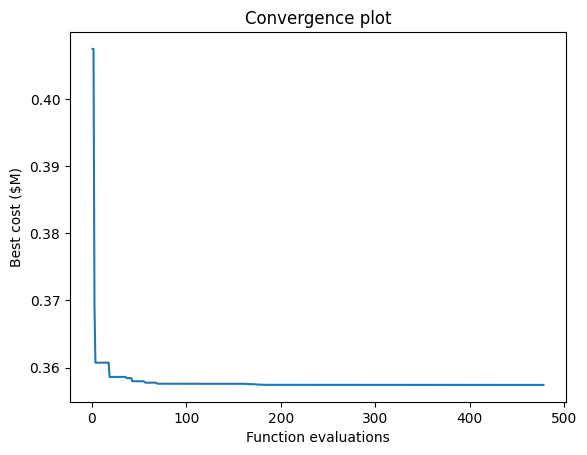

In [7]:
import matplotlib.pyplot as plt
import numpy as np


plt.plot(range(1,len(opt_list)+1), np.array(opt_list)/10**6)
plt.ylabel('Best cost ($M)')
plt.xlabel('Function evaluations')
plt.title('Convergence plot')
plt.savefig('PAMSO_convergence1.pdf')
plt.show()

In [8]:
MBBF(x_min)

{1: 2515.150629223026, 2: 909.0923213794828}


357408.98420010053